In [1]:
import skeliner as sk
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pywarper import Warper
from pywarper.utils import read_sumbul_et_al_chat_bands
from pywarper.stats import get_convex_hull, get_hull_centroid, get_xy_center_of_mass
from matplotlib.colors import Normalize



In [2]:
# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt", unit="physical") # should be the off sac layer
chat_bottom = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt", unit="physical") # should be the on sac layer
# but the image can be flipped
if chat_top["z"].mean() > chat_bottom["z"].mean():
    off_sac_points = chat_top
    on_sac_points = chat_bottom
else:
    off_sac_points = chat_bottom
    on_sac_points = chat_top

In [3]:
cell_path = "../tests/data/Image013-009_01_raw_latest_Uygar.swc"
w = Warper(off_sac_points=off_sac_points, on_sac_points=on_sac_points, swc_path=cell_path, verbose=True)
voxel_resolution = np.array([0.4, 0.4, 0.5])  # in microns
w.skeleton.nodes *= voxel_resolution # convert to microns

# in the original matlab code, all data were in voxel space and converted to microns at the end
# but it makes more sense to work in microns from the beginning, so that there will be less unit conversion in between

[pywarper] Loading skeleton → ../tests/data/Image013-009_01_raw_latest_Uygar.swc


In [4]:
# Given the sampled points on the off and on sac ChAT bands, we fit (extrapolate) the surfaces 
# using `pygridfit` from (0, xmax) x (0, ymax) internally.

w.fit_surfaces(
    xmax=max(off_sac_points["x"].max(), on_sac_points["x"].max()), # these are already the default if not specified
    ymax=max(off_sac_points["y"].max(), on_sac_points["y"].max()), 
    stride=3, 
    smoothness=15, 
)

[pywarper] Fitting SAC surfaces …
↳ fitting OFF (max) surface
    done in 0.07 seconds.
↳ fitting ON (min) surface
    done in 0.06 seconds.


In [5]:
# There are three ways to build the mapping:
# 1. Using the skeleton bounds (local bounds)
# 2. Using the surface bounds (global bounds)
# 3. Using a custom bounding box

# w.build_mapping(bounds="local", conformal_jump=2, n_anchors=4) # default is local, which is faster because it's smaller
w.build_mapping(bounds="global", conformal_jump=2, n_anchors=8) # n_anchors needs to be larger than 4 if the global bounds are much larger than the skeleton


[pywarper] Building mapping …
↳ mapping ON (min) surface …
    done in 0.27 seconds.
↳ mapping OFF (max) surface …
    done in 0.28 seconds.


In [6]:
w.warp_skeleton(
    z_profile_extends=[-25, 25], # extend the z profile by 25 microns in both directions, if None, it will be inferred.
    z_profile_nbins=50, # number of bins in the z profile.
    z_profile_hdr_mass=0.95, # highest density region mass.
    xy_profile_extends=[50, 300, 50, 300], # extend the xy profile by 300 microns in both directions, if None, it will be inferred.
    xy_profile_nbins=25, # number of bins in the xy profile.
)

[pywarper] Warping skeleton...
    done in 1.41 seconds.


[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


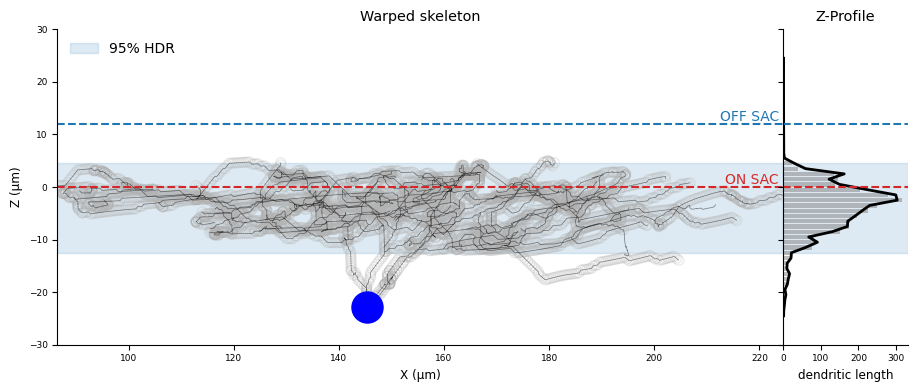

In [7]:
# Flattened view + Z-profile -------------------------------------------
###############################################################################
# --- constants ---------------------------------------------------------------
FIG_H_IN      = 4.0       # fixed physical height  [inch]
RIGHT_W_IN    = 1.25      # physical width of the right pane [inch]
BASE_FS_PT = 0.030 * FIG_H_IN * 72            # 3 % of fig-height
mpl.rcParams.update({                         # applied once per script
    "font.size"        : BASE_FS_PT,
    "axes.labelsize"   : BASE_FS_PT * 1,
    "axes.titlesize"   : BASE_FS_PT * 1.2,
    "xtick.labelsize"  : BASE_FS_PT * 0.75,
    "ytick.labelsize"  : BASE_FS_PT * 0.75,
    "legend.fontsize"  : BASE_FS_PT * 0.75,
})
    
###############################################################################

# --------------------------------------------------------------------------- #
# 1.  Work out how wide the *left* pane must be so that 1 µm on X == 1 µm on Z
# --------------------------------------------------------------------------- #
xyz         = w.warped_skeleton.nodes                # (N, 3) columns → (x, y, z)
x_span_um   = np.ptp(xyz[:, 0])
z_span_um   = np.ptp(xyz[:, 2])
LEFT_W_IN   = FIG_H_IN * (x_span_um / z_span_um)  # 1:1 scale
FIG_W_IN    = LEFT_W_IN + RIGHT_W_IN              # total figure width

# --------------------------------------------------------------------------- #
# 2.  Make the figure — NO gap between the two cells
# --------------------------------------------------------------------------- #
fig, (ax_nodes, ax_prof) = plt.subplots(
    1, 2,
    figsize=(FIG_W_IN, FIG_H_IN),
    sharey=True,
    gridspec_kw={'width_ratios': [LEFT_W_IN, RIGHT_W_IN], 'wspace': 0}
)

# critical: push the *patch* of each axes against the neighbour
ax_nodes.set_anchor('E')   # left pane anchored to its *east* side
ax_prof.set_anchor('W')    # right pane anchored to its *west* side

# --------------------------------------------------------------------------- #
# 3.  Left panel — arbor, true 1:1 scale
# --------------------------------------------------------------------------- #
sk.plot2d(w.warped_skeleton, plane="xz",
        ax=ax_nodes, color_by="ntype", skel_cmap="Set2")
ax_nodes.set_xlabel('X (µm)')
ax_nodes.set_ylabel('Z (µm)')
ax_nodes.set_aspect('equal', adjustable='box')     # keep the scale

ax_nodes.scatter(
    w.warped_skeleton.nodes[0, 0],
    w.warped_skeleton.nodes[0, 2],
    s=500, color='blue', zorder=99,
)

colors = ["C3", "C0"]
for i, y in enumerate((0, 12)):
    ax_nodes.axhline(y, ls='--', c=colors[i])
ax_nodes.text(ax_nodes.get_xlim()[1],  0, 'ON SAC ',  va='bottom', ha='right', fontsize=10, color=colors[0])
ax_nodes.text(ax_nodes.get_xlim()[1], 12, 'OFF SAC ', va='bottom', ha='right', fontsize=10, color=colors[1])
ax_nodes.spines['top'].set_visible(False)
ax_nodes.spines['right'].set_visible(False)
ax_nodes.set_title("Warped skeleton")
# --------------------------------------------------------------------------- #
# 4.  Right panel — fixed-width stratification profile
# --------------------------------------------------------------------------- #
zp = w.warped_skeleton.extra["z_profile"]
ax_prof.plot(zp["distribution"], zp["x"], lw=2, c='black')
ax_prof.barh(zp["x"], zp["histogram"], color='gray', alpha=0.5)
ax_prof.set_xlabel('dendritic length')
ax_prof.set_title('Z-Profile')

ax_prof.axhline(0,  ls='--', c=colors[0])
ax_prof.axhline(12, ls='--', c=colors[1])
ax_prof.spines['top'  ].set_visible(False)
ax_prof.spines['right'].set_visible(False)

for ax in (ax_nodes, ax_prof):
    ax.set_ylim([-30, 30])

z_hdr = w.warped_skeleton.extra["z_profile"]["hdr"]

for i, (z_lo, z_hi) in enumerate(z_hdr):
    # left panel (xz view)
    ax_nodes.axhspan(z_lo, z_hi,
                     color=f"C{i}", alpha=0.15, zorder=0, label="95% HDR")

    # right panel (profile)
    ax_prof.axhspan(z_lo, z_hi,
                    color=f"C{i}", alpha=0.15, zorder=0)

ax_nodes.legend(
    loc='upper left', frameon=False, fontsize=10,
)
# --------------------------------------------------------------------------- #
fig.tight_layout(pad=0, rect=(0., 0., 1., 0.93))


In [8]:

hull = get_convex_hull(w.warped_skeleton.nodes[:, 0:2])
com_hull = get_hull_centroid(hull)

xy_profile = w.warped_skeleton.extra["xy_profile"]
xy_dist = xy_profile["distribution"]
xy_x = xy_profile["x"]
xy_y = xy_profile["y"]
com_xy = get_xy_center_of_mass(xy_x, xy_y, xy_dist)

[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


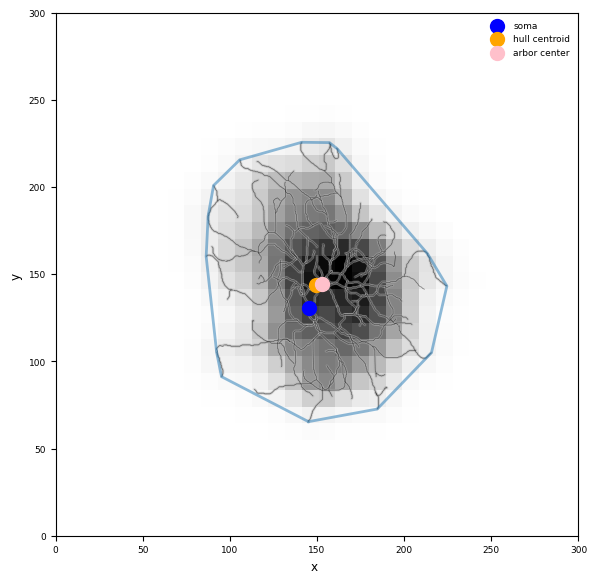

In [9]:


xy_profile = w.warped_skeleton.extra["xy_profile"]
xy_dist = xy_profile["distribution"]
xy_x = xy_profile["x"]
xy_y = xy_profile["y"]

fig, ax = plt.subplots(figsize=(6, 6))

sk.plot2d(
    w.warped_skeleton, plane="xy", ax=ax,
    xlim=(0, 300), ylim=(0, 300),
    color_by="ntype", skel_cmap="Set2"
)


z_nodes = w.warped_skeleton.nodes[:, 2]
for i, (z_lo, z_hi) in enumerate(z_hdr):
    layer = (z_nodes >= z_lo) & (z_nodes <= z_hi)
    hull = get_convex_hull(w.warped_skeleton.nodes[layer, 0:2])
    ax.plot(hull[:, 0], hull[:, 1],  alpha=0.5, linewidth=2, color=f"C{i}")

im = ax.imshow(
    xy_dist.T, origin="lower",
    extent=(xy_x[0], xy_x[-1], xy_y[0], xy_y[-1]),
    cmap="Greys", norm=Normalize(vmin=0, vmax=xy_dist.max()),
)

ax.scatter(
    w.warped_skeleton.nodes[0, 0],
    w.warped_skeleton.nodes[0, 1],
    s=100, color='blue', zorder=99, label='soma',
)

ax.scatter(
    com_hull[0], com_hull[1],
    s=100, color='orange', zorder=99, label='hull centroid'
)

ax.scatter(
    com_xy[0], com_xy[1],
    s=100, color='pink', zorder=99, label='arbor center'
)


ax.legend(frameon=False)

In [10]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-06-18 14:14:13CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.3.0

numpy     : 2.2.6
skeliner  : 0.1.6
matplotlib: 3.10.3
pywarper  : 0.2.1

Watermark: 2.5.0

